# University of Aberdeen

## Applied AI (CS5079)

### Tutorial (Day 5) - Creating a Chatbot for Sentiment Prediction

---

The practical is based on Chapters 8 and 11 of Practical Machine Learning with Python (D. Sarkar et al.), and the slides covered in our lectures.


## Learning Outcomes

On successful completion of this component a student will have demonstrated competence in analysing and predicting on business data.

### In this tutorial, we will use the following libraries and modules

In [86]:
# Essential libraries for data representation
import pandas as pd
import numpy as np

# Library for plotting
from jcopml.plot import plot_missing_value
import matplotlib.pyplot as plt
import math
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm

# Statistics libraries
import scipy.stats

#ML libraries
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

# Handling time
import datetime

## Customer Segmentation

In this practical, we will try to discover information from a business' customer base to identify customer purchase behaviors and patterns. Possible benefits and applications are targetted marketing and advertisements, better product placement and finding latent customer segments.

### Exploratory Data Analysis


We will be using the retail transactions dataset from UCI Machine Learning Repository: http://archive.ics.uci.edu/ml/datasets/online+retail. The dataset has been imported as `Online Retail.xlsx` but you can download it directly from the original website if you are not using Codio.

1.1. Import and print a snapshot and the shape of the dataset. You can use Pandas' method `read_excel`.

In [2]:
retail_df = pd.read_excel(io=r'Online Retail.xlsx')
print(retail_df.shape)
retail_df.head(5)

(541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


1.2. Print the datatypes of each column and write a quick explanation of its content.

In [3]:
retail_df.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

* InvoiceNo: An identifier for the invoice. The same number shared across rows means that those transactions were performed in a single invoice (multiple purchases).
* StockCode: Identifier for items contained in an invoice.
* Description: Textual description of each of the stock item.
* Quantity: The quantity of the item purchased.
* InvoiceDate: Date of purchase.
* UnitPrice: Value of each item.
* CustomerID: Identifier for customer making the purchase.
* Country: Country of customer.

1.3. Print the number of entries for each country and determine the top 5 countries the retailer is shipping its items to.

In [4]:
retail_df['Country'].value_counts().reset_index()[:5]

,index,Country
0,United Kingdom,495478
1,Germany,9495
2,France,8557
3,EIRE,8196
4,Spain,2533


1.4. Use jcopml's function `plot_missing_value` from the `plot` module to visualize the missing values. Putting the parameter `return_df` will return the number and percentage of missing values for each attribute.

,missing_value,%
InvoiceNo,0,0.00
StockCode,0,0.00
Description,1454,0.27
Quantity,0,0.00
InvoiceDate,0,0.00
UnitPrice,0,0.00
CustomerID,135080,24.93
Country,0,0.00


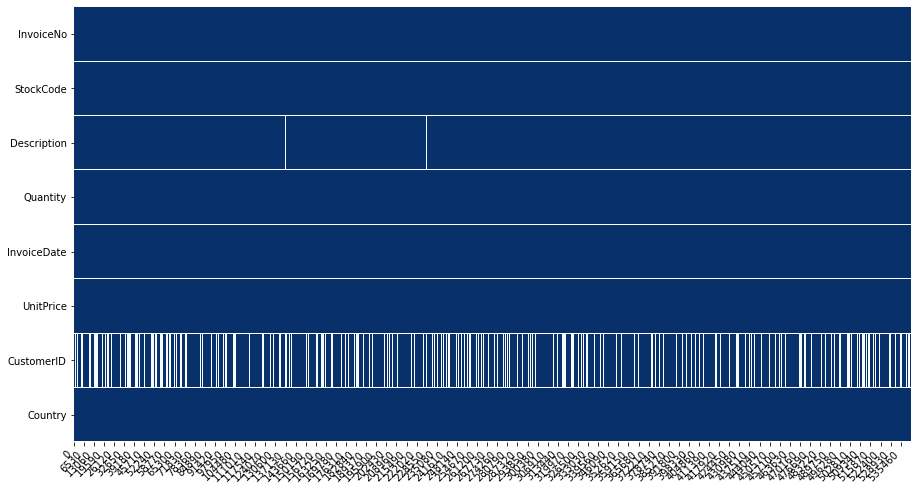

In [5]:
plot_missing_value(retail_df, return_df = True)

1.5. Print the number of __unique__ customers and use Pandas' `describe` method to display some statistics for the numertical attributes of the dataset. What can you observe?

In [6]:
print("There are {} distinct customers.".format(retail_df['CustomerID'].unique().shape))

retail_df.describe()

There are (4373,) distinct customers.


,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


1.6. Compute the interquartile range ($IQR = Q3-Q1$) for the numerical attributes (`UnitPrice`, `Quantity`). In our particular tutorial, we will remove the entries that are below the lower bound ($Q1 - 1.5 \cdot IQR$) and above the upper bound ($Q3 + 1.5 \cdot IQR$).

In [7]:
def filter_outliers(dataframe, attributes):
    for att in attributes:
        q1 = retail_df[att].quantile(0.25)
        q3 = retail_df[att].quantile(0.75)
        IQR = q3 - q1
        LB = float(q1) - (1.5 * IQR)
        UB = float(q3) + (1.5 * IQR)
        
        #FILTRATION
        dataframe = dataframe[dataframe[att] >= LB][dataframe[att] <= UB]
    return dataframe

filtered_retail_df = filter_outliers(retail_df, ["UnitPrice", "Quantity"])
print(filtered_retail_df.shape)
filtered_retail_df.describe()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.


(444108, 8)


,Quantity,UnitPrice,CustomerID
count,444108.000000,444108.000000,327498.000000
mean,4.803066,2.694544,15345.003670
std,4.616762,1.930320,1704.517156
min,-12.000000,0.000000,12347.000000
25%,1.000000,1.250000,14041.000000
50%,3.000000,2.080000,15287.000000
75%,8.000000,3.750000,16843.000000
max,23.000000,8.330000,18287.000000


1.7. Print the percentage of the dataset's entries made by the top 10 customers. You can use Pandas' `value_counts` method.

In [8]:
customer_value_counts = filtered_retail_df['CustomerID'].value_counts()

(customer_value_counts/ sum(customer_value_counts) *100).iloc[:10].cumsum()
#The top 10 customers represent nearly 10% of the total number of entries

17841.0    2.303526
14096.0    3.705977
14911.0    4.993924
12748.0    6.272099
14606.0    7.064471
15311.0    7.672108
13263.0    8.166767
15039.0    8.586617
13089.0    8.967994
18118.0    9.341431
Name: CustomerID, dtype: float64

1.8. In the rest of this tutorial, we will only focus on transactions with UK customers with a non null `CustomerID`. Create a restricted dataset, called `UK_retail` and add a new attribute `total` corresponding to total amount (`Quantity` multiplied by `UnitPrice`). Print the dataset description.

In [9]:
UK_retail = filtered_retail_df[filtered_retail_df.Country == "United Kingdom"]
UK_retail['total'] = UK_retail.Quantity * UK_retail.UnitPrice
UK_retail = UK_retail[~ (UK_retail.CustomerID.isnull())]
print(UK_retail.shape)

UK_retail.describe()

(296862, 9)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Quantity,UnitPrice,CustomerID,total
count,296862.000000,296862.000000,296862.000000,296862.000000
mean,5.366271,2.501643,15574.292099,11.051953
std,4.721272,1.853320,1590.715693,11.744748
min,-12.000000,0.000000,12747.000000,-91.800000
25%,2.000000,1.250000,14240.000000,3.300000
50%,4.000000,1.950000,15544.000000,8.250000
75%,10.000000,3.250000,16942.000000,16.350000
max,23.000000,8.290000,18287.000000,168.300000


1.9. Remove all the entries with a negative total, i.e. the transactions corresponding to returns.

In [10]:
UK_retail = UK_retail[UK_retail.total >= 0]

## Clustering strategies for customer segmentation

Considering the limited nature of the dataset, we will use the Recency, Frequency and Monetary value (RFM) model to assign a value to custormers.

* Recency: How recently a customer purchased from the retailer
* Frequency: How frequent a customer made transactions with the retailer
* Monetary value: The value of all the transactions that the customer made with the retailer

### Recency, Frenquency & Monetary value

2.1. What is the date $x$ of the newest entry in the dataset? Create a `Timestamp`, called `reference_day`, with the value $x + 1$ day.

In [11]:
reference_day = UK_retail.InvoiceDate.max() + datetime.timedelta(days=1)

2.2. For each customer, compute the number of days between their last transaction and `reference_day` (recency). Print the historgram of sales recency (using `pyplot`'s `hist` function) where the $x$-axis is the recency and the $y$-axis is the number of transactions. What can you conclude?

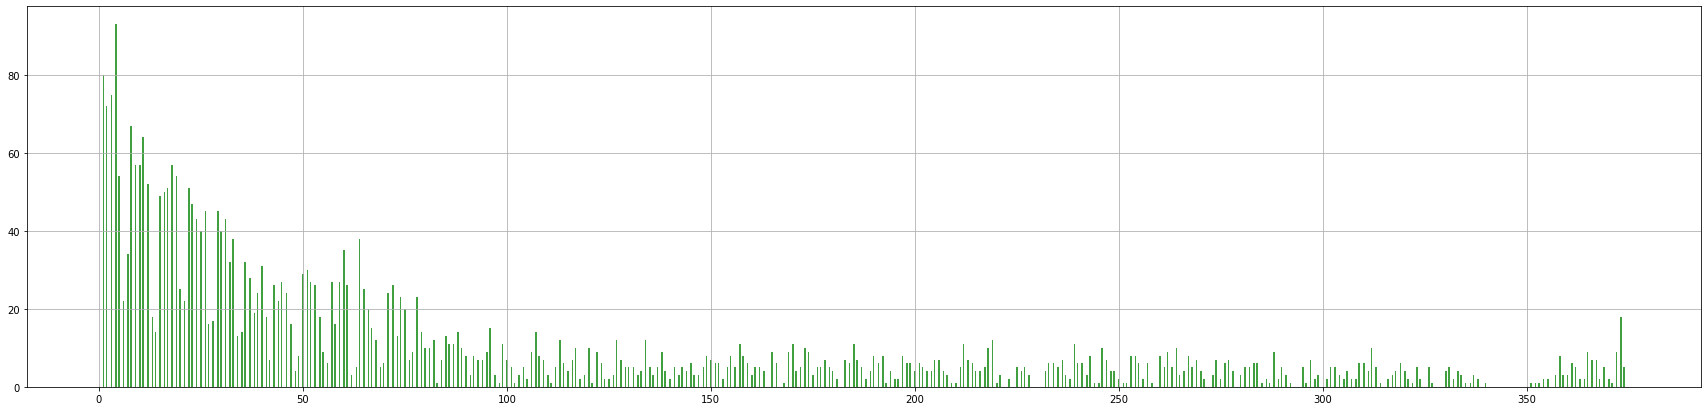

In [29]:
customer_last_transaction = (reference_day - UK_retail.groupby(["CustomerID"]).InvoiceDate.max()).astype('timedelta64[D]')
customer_last_transaction = ([[index, recency] for index, recency in zip(customer_last_transaction.index, customer_last_transaction.values)])
customer_last_transaction = pd.DataFrame(customer_last_transaction,columns=["CustomerID", "Recency"])

# Casting types
customer_last_transaction.CustomerID = customer_last_transaction.CustomerID.astype('int32') 
customer_last_transaction.Recency = customer_last_transaction.Recency.astype('int32') 

x = customer_last_transaction.Recency
plt.rcParams['figure.figsize']= (30,7)
n, bins, patches = plt.hist(x, 1000, facecolor='green', alpha=0.75)
plt.grid(True)
plt.show()

2.3. For each customer, compute the frequency (the number of transactions) and monetary value. Create a new dataframe, called `RFM_df` with the attributes `CustomerID`, `Recency`, `Monetary_value` and `Frequency`.

In [43]:
RFM_df = customer_last_transaction
customer_monetary = UK_retail.groupby(["CustomerID"]).total.sum()
RFM_df["Monetary_value"] = customer_monetary.values

customer_freq = UK_retail.groupby(["CustomerID"]).total.count()
RFM_df["Frequency"] = customer_freq.values

customer_last_transaction

,CustomerID,Recency,Monetary_value,Frequency
0,12747,2,1731.89,69
1,12748,1,19404.13,4162
2,12749,4,2715.22,148
3,12820,3,824.14,49
4,12821,214,60.12,4
...,...,...,...,...
3756,18280,278,160.70,9
3757,18281,181,46.92,5
3758,18282,8,113.13,8
3759,18283,4,2051.98,752


2.4. Since the range of the attributes of our `RFM_df` dataframe vary greatly, we will normalize them using a log scale. Add the corresponding attributes `Recency_log`, `Monetary_value_log` and `Frequency_log` by applying the `math.log` functions to the existing columns.

In [47]:
RFM_df["Recency_log"] = RFM_df.Recency.apply(math.log)
RFM_df["Monetary_value_log"] = RFM_df.Monetary_value.apply(math.log)
RFM_df["Frequency_log"] = RFM_df.Frequency.apply(math.log)

# We show the dataset
RFM_df

,CustomerID,Recency,Monetary_value,Frequency,Recency_log,Monetary_value_log,Frequency_log
0,12747,2,1731.89,69,0.693147,7.456969,4.234107
1,12748,1,19404.13,4162,0.000000,9.873241,8.333751
2,12749,4,2715.22,148,1.386294,7.906628,4.997212
3,12820,3,824.14,49,1.098612,6.714340,3.891820
4,12821,214,60.12,4,5.365976,4.096343,1.386294
...,...,...,...,...,...,...,...
3756,18280,278,160.70,9,5.627621,5.079539,2.197225
3757,18281,181,46.92,5,5.198497,3.848444,1.609438
3758,18282,8,113.13,8,2.079442,4.728538,2.079442
3759,18283,4,2051.98,752,1.386294,7.626560,6.622736


2.5. Using a 3D scatter plot, display the customer space, i.e. each dot will corresponds to a customer and the $x$-axis, $y$-axis and $z$-axis will be the recency, frequency and monetary value (in a log scale) respectively. What can you notice?

Text(0.5, 0, 'Monetary value')

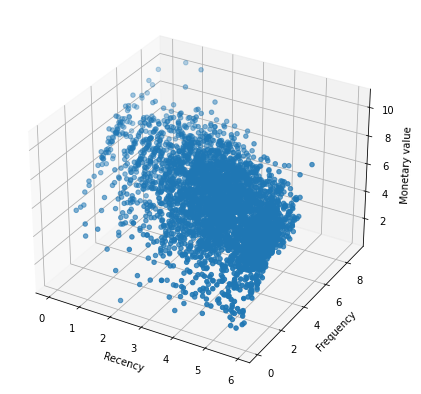

In [54]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(RFM_df.Recency_log, RFM_df.Frequency_log, RFM_df.Monetary_value_log)
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary value')

### Silhouette Analysis

2.6. You can use Scikit-learn's `KMeans` to create clusters using the attributes `Recency_log`, `Monetary_value_log` and `Frequency_log`. You can use Scikit-learn's `silhouette_score` function to fund the optimal number of clusters. The score is computed using the following equation:

$$ \frac{(b-a)}{\max(b-a)}$$

where $a$ is the mean intra-cluster distance and $b$ is the mean nearest-cluster distance. The best score is $1$ and the worst score is $-1$.

In [79]:
for i in range(2,11):
    clusterer = KMeans(n_clusters = i)
    X = RFM_df[["Recency_log","Frequency_log","Monetary_value_log"]]
    cluster_labels = clusterer.fit_predict(X)
    print("Number of clusters: ",i," Score: ",silhouette_score(X, cluster_labels))

Number of clusters:  2  Score:  0.39954244611199863
Number of clusters:  3  Score:  0.3106400227496694
Number of clusters:  4  Score:  0.30804811284635697
Number of clusters:  5  Score:  0.3065798244065511
Number of clusters:  6  Score:  0.28816669407040574
Number of clusters:  7  Score:  0.29113913990196366
Number of clusters:  8  Score:  0.28979684304727615
Number of clusters:  9  Score:  0.2809457232733687
Number of clusters:  10  Score:  0.284822865397804


2.7. The Scikit-learn's `silhouette_samples` will return the silhouette score for each sample. For $k=2$, $k=3$, $k=4$, and $k=5$ compute the silhouette score for each sample, group them by clusters and sort them by decreasing values. You can represent them using Matplotlib's `fill_betweenx` representation. For each value of $k$, color the 3D scatter plot obtained in 2.5. to represent the clusters. What can you notice?

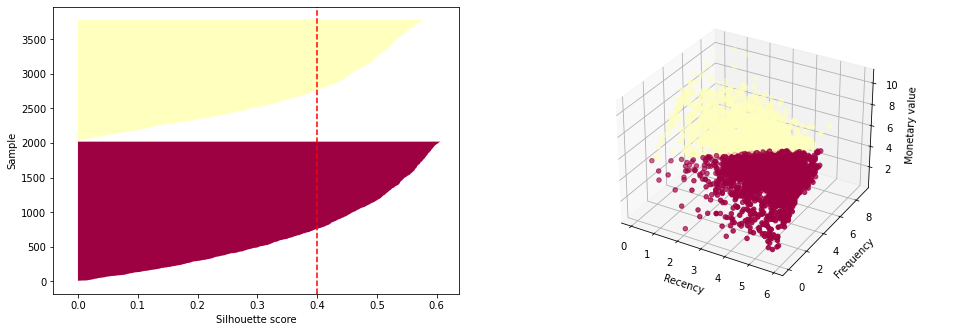

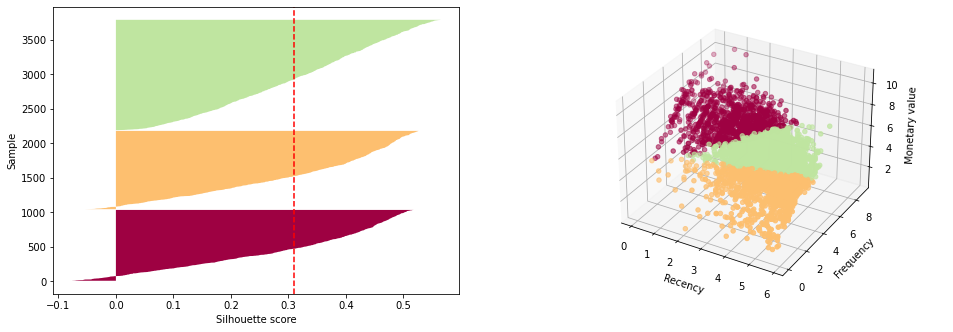

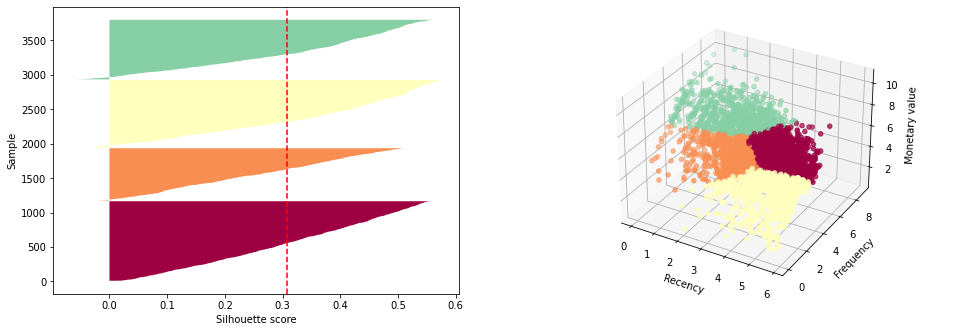

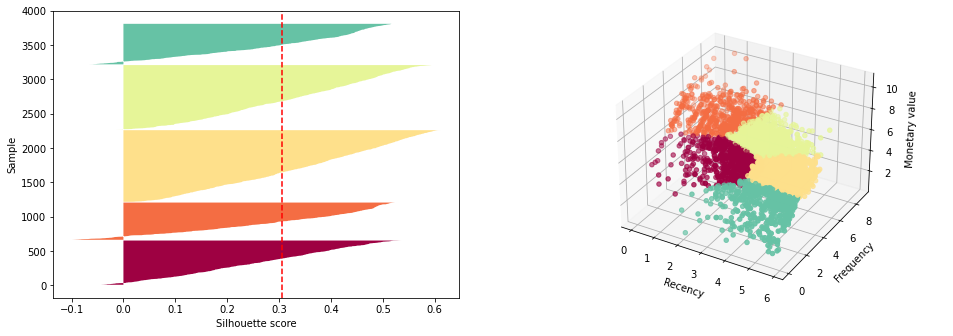

In [114]:
for nb_clusters in [2,3,4,5]:
    fig, (ax1, ax2)= plt.subplots(nrows=1, ncols=2, figsize=plt.figaspect(0.33)) #Thrice as wide as it is tall

    clusterer = KMeans(n_clusters = nb_clusters)
    X = RFM_df[["Recency_log","Frequency_log","Monetary_value_log"]]
    cluster_labels = clusterer.fit_predict(X)
    sil_scores = silhouette_samples(X,cluster_labels)
    
    y_lower = 10
    for i in range(nb_clusters):
        i_cluster_scores = sil_scores[cluster_labels==i]
        i_cluster_scores.sort()
        
        y_upper = y_lower + i_cluster_scores.shape[0]
        
        #We draw the scores for the cluster
        color = cm.get_cmap("Spectral")(float(i) / nb_clusters)
        ax1.fill_betweenx(np.arange(y_lower,y_upper),0, i_cluster_scores, facecolor=color)
        y_lower = y_upper+10        
    
    # We draw the average silhouette score
    ax1.axvline(x=silhouette_score(X, cluster_labels), color="red", linestyle="--")
    ax1.set_xlabel('Silhouette score')
    ax1.set_ylabel('Sample')
    
    # We color the customers w.r.t. the clusters
    ax2.axis('off')
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    ax2.scatter(RFM_df.Recency_log, RFM_df.Frequency_log, RFM_df.Monetary_value_log, c=cm.get_cmap("Spectral")(cluster_labels / nb_clusters))
    ax2.set_xlabel('Recency')
    ax2.set_ylabel('Frequency')
    ax2.set_zlabel('Monetary value')
        

    
    plt.show()
        

### Cluster Analysis

2.8. For $k=3$ and $k=5$, print the values of `Frequency`, `Recency` and `Monetary_value` for the center of each cluster. You can use `cluster_centers_` to obtain the list of cluster centers from `KMeans`. What can you say?

In [118]:
for i in [3,5]:
    clusterer = KMeans(n_clusters = i)
    features_vec = ["Recency_log","Frequency_log","Monetary_value_log"]
    X = RFM_df[features_vec]
    cluster_labels = clusterer.fit_predict(X)
    print(pd.DataFrame(np.exp(clusterer.cluster_centers_), columns = features_vec))
    print("Number of clusters: ",i," Score: ",silhouette_score(X, cluster_labels))

   Recency_log  Frequency_log  Monetary_value_log
0   114.664102       6.975660          106.645033
1     8.493085     124.540367         1486.845034
2    62.728417      39.992232          486.662176
Number of clusters:  3  Score:  0.3106400227496694
   Recency_log  Frequency_log  Monetary_value_log
0    15.715961      21.129387          272.266766
1   127.616777       4.179335           68.866411
2     4.775121     173.536548         2094.397070
3   146.240348      22.624162          288.537782
4    41.058380      88.262295         1048.628598
Number of clusters:  5  Score:  0.30666416015767384


* For the three clusters configuration, we can notice that there are three distinct values of monetary values. Cluster 1 represents customers that buy frequently (and also spend the most money). Clusters 0 and 2 corresponds to customer with low or medium budgets.

* For the 5 cluster configuration, we can notice that the customers who spend a lot of money are composed of two subgroups:
    * Those who spend a decent amount but that are not as frequent (cluster 4)
    * Those who often shop with a high amount (cluster 2)